<a href="https://colab.research.google.com/github/msiplab/EicEngLabIV/blob/develop/example02_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 実験Ⅳ－２　時系列データの分析

1. サンプルデータの読み込み
1. 平均 $\mu$ と分散 $\gamma_0$ の推定
1. 自己共分散関数 $\gamma_k$ と自己相関関数 $\rho_k$ の推定

新潟大学工学部工学科　電子情報通信プログラム 

## 準備

In [13]:
!pip install bs4
!pip install japanize-matplotlib
%matplotlib inline

import warnings
warnings.simplefilter('ignore') #警告を無視（コメントアウト推奨）

from urllib import request
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd
import pandas.tseries.offsets as offsets
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib #日本語化matplotlib
sns.set(font="IPAexGothic") #日本語フォント設定

## Webからの水位データの読み込み

新潟県河川防災情報システムより
http://doboku-bousai.pref.niigata.jp/kasen/index.html

河川ライブ映像 http://www.hrr.mlit.go.jp/shinano/live/map1.html# （小千谷市11番目）

以下のPythonライブラリを利用
- urllib
- bs4


In [14]:
# 水位観測所IDの設定
loc = '260' # 

# 解析期間の設定
dts = '2020070101' # 開始日時
dte = '2020072300' # 終了日時
interval = 1 # hour

# Webからの水位情報抽出
dts00 = pd.to_datetime(dts+'00')
dte00 = pd.to_datetime(dte+'00')
td = dte00 - dts00
durationinhours = int(td.total_seconds()/(3600))
t = [ [] for idx in range(durationinhours) ]
y = [ 0.0 for idx in range(durationinhours) ]
idt = dts00
idx = 0
while idt < dte00:
    # 水位抽出日時の設定
    strdt = idt.strftime('%Y%m%d%H%M')
    ts = pd.to_datetime(idt).tz_localize('Asia/Tokyo')

    # URLの設定
    url = 'http://doboku-bousai.pref.niigata.jp/kasen/servlet/bousaiweb.servletBousaiGraph?ga=4&gk=0&gn=0&gl=0&gw=0&go=0&omp=0&opn=0&spn=0&tvm=0&tsw=0&sv=3&dk=2&mp=0&no=0&fn=0&pg=6&sitept=0&unq=12062215494&nwg=0&tmg={0}&sn={1}&wsl=3&wl=1&rg=1&sy=gra_river&psn=0&=&nw=0&tm={0}&logflg=0'.format(strdt,loc)

    # 指定した時刻の水位情報抽出
    response = request.urlopen(url)
    soup = BeautifulSoup(response)
    response.close()
    if idt == dts00:
        strtitle = soup.title.text.strip()
    #print(soup.find('td', class_='tableHeaderCast').text.strip())
    strwaterlevel = soup.find('td', class_='tableHeaderItemCen').text.strip().replace('m','')
    try:
        waterlevel = float(strwaterlevel)
    except ValueError:
        waterlevel = np.nan

    # リストへのデータ登録
    t[idx] = ts
    y[idx] = waterlevel

    # 時間を更新
    idx += 1
    idt += offsets.Hour(interval)


## 時系列データをpandas.DataFrameオブジェクトに変換

pandas ライブラリの DataFrame オブジェクトに変換

- t: 時刻
- y: データの値


In [15]:
df_timeseries= pd.DataFrame({'t': t, 'y': y})
display(df_timeseries)

,t,y
0,2020-07-01 01:00:00+09:00,42.29
1,2020-07-01 02:00:00+09:00,42.31
2,2020-07-01 03:00:00+09:00,42.32
3,2020-07-01 04:00:00+09:00,42.43
4,2020-07-01 05:00:00+09:00,42.52
...,...,...
522,2020-07-22 19:00:00+09:00,43.76
523,2020-07-22 20:00:00+09:00,43.67
524,2020-07-22 21:00:00+09:00,43.55
525,2020-07-22 22:00:00+09:00,43.34


## 時系列データをプロット

- y: 原系列
- y_fillna: 欠損個所を前の値で補間


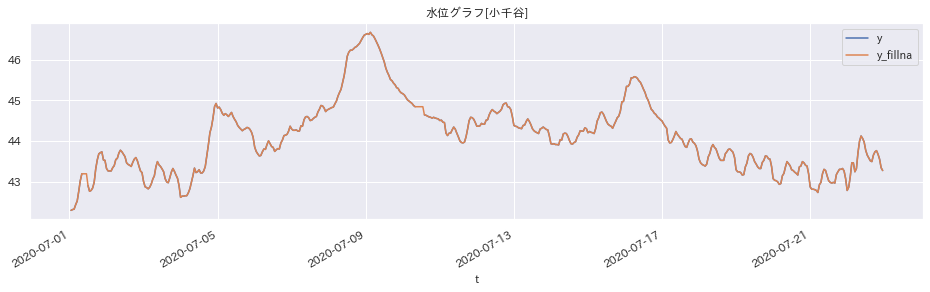

In [16]:
df_timeseries['y_fillna'] = df_timeseries['y'].fillna(method='ffill').astype(float) 
ax = df_timeseries.plot(x='t', y={'y', 'y_fillna'}, figsize=(16,4), title=strtitle)


ヒストグラムをプロット

Text(0.5, 1.0, '水位グラフ[小千谷]')

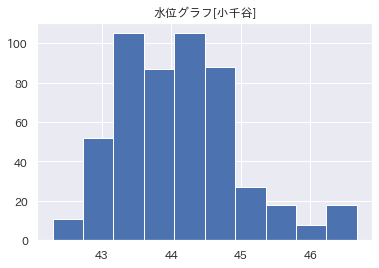

In [17]:
ax = df_timeseries.hist('y')
ax[0][0].set_title(strtitle)

## 平均 $\mu$ と分散 $\gamma_0$ の推定

- mean(): 標本平均を計算
- var(): 標本分散を計算

pandas.DataFrame オブジェクトのvar() メソッドのオプションで 

- ddof = 0 とすると N で割る最尤推定
- ddof = 1 とすると (N-1)で割る不偏推定 ※デフォルト

In [18]:
y_series = df_timeseries['y']
mu = y_series.mean()
gamma0 = y_series.var(ddof=1) 
print('平均 = {:f}, 分散 = {:f}'.format(mu,gamma0))

平均 = 44.105164, 分散 = 0.757792


## 自己共分散関数 $\gamma_k$ と自己相関関数 $\rho_k$ の推定

y_series は pandas.Series のオブジェクトとなっている。
pandas.Seriesオブジェクトは以下のメソッドを備える。

- cov() は共分散の不偏推定を計算
- corr() は相関の不偏推定を計算

※不偏推定から最尤推定への切替はできない


In [19]:
nlags = 40
for lag in range(nlags+1):
    gammak = y_series.cov(y_series.shift(lag))
    rhok = y_series.corr(y_series.shift(lag))
    print('γ{0:d} = {1:f}, ρ{0:d} = {2:f}'.format(lag,gammak,rhok))

γ0 = 0.757792, ρ0 = 1.000000
γ1 = 0.750077, ρ1 = 0.993103
γ2 = 0.735674, ρ2 = 0.978063
γ3 = 0.717801, ρ3 = 0.958768
γ4 = 0.699719, ρ4 = 0.938108
γ5 = 0.683130, ρ5 = 0.918007
γ6 = 0.669395, ρ6 = 0.900689
γ7 = 0.659552, ρ7 = 0.887028
γ8 = 0.652433, ρ8 = 0.876847
γ9 = 0.648186, ρ9 = 0.867686
γ10 = 0.643203, ρ10 = 0.857831
γ11 = 0.635437, ρ11 = 0.844638
γ12 = 0.621308, ρ12 = 0.826675
γ13 = 0.603912, ρ13 = 0.804875
γ14 = 0.584184, ρ14 = 0.779845
γ15 = 0.563639, ρ15 = 0.753456
γ16 = 0.543911, ρ16 = 0.727581
γ17 = 0.526518, ρ17 = 0.703989
γ18 = 0.511753, ρ18 = 0.684224
γ19 = 0.500739, ρ19 = 0.669340
γ20 = 0.492360, ρ20 = 0.658059
γ21 = 0.485704, ρ21 = 0.649325
γ22 = 0.478002, ρ22 = 0.640257
γ23 = 0.468750, ρ23 = 0.629784
γ24 = 0.455967, ρ24 = 0.615249
γ25 = 0.438855, ρ25 = 0.594419
γ26 = 0.419606, ρ26 = 0.570266
γ27 = 0.399747, ρ27 = 0.545038
γ28 = 0.380728, ρ28 = 0.520611
γ29 = 0.363979, ρ29 = 0.498810
γ30 = 0.350681, ρ30 = 0.481440
γ31 = 0.341232, ρ31 = 0.468903
γ32 = 0.335291, ρ32 = 0.4611

## 時系列解析ライブラリ

時系列解析には，statsmodelsライブラリも利用できる。

- acovf() は自己共分散関数を計算
- acf() は自己相関関数を計算

各メソッドのオプション unbiased = True で不偏推定，Falseで最尤推定となる．



In [20]:
import statsmodels.api as sm
from statsmodels.tsa import stattools

#欠損値がある場合は nan が含まれる．
#欠損個所を補間したデータを使わない場合は以下の行をコメントアウトする
y_series = df_timeseries['y_fillna']

print('自己共分散関数')
y_acovf = stattools.acovf(y_series,unbiased=True)
display(y_acovf)
print('自己相関関数')
y_acf = stattools.acf(y_series,unbiased=True)
display(y_acf)


自己共分散関数


array([ 7.54738558e-01,  7.47141611e-01,  7.33671959e-01,  7.17429185e-01,
        7.00656979e-01,  6.84791866e-01,  6.71509526e-01,  6.61381189e-01,
        6.53762510e-01,  6.47217578e-01,  6.40257550e-01,  6.31132725e-01,
        6.17935420e-01,  6.01850024e-01,  5.83299308e-01,  5.63603728e-01,
        5.44351941e-01,  5.27160826e-01,  5.12650340e-01,  5.01670295e-01,
        4.93883093e-01,  4.87765978e-01,  4.80687330e-01,  4.72139778e-01,
        4.60290568e-01,  4.44284176e-01,  4.26355634e-01,  4.07933609e-01,
        3.90529363e-01,  3.75442863e-01,  3.63783426e-01,  3.55645570e-01,
        3.50684018e-01,  3.47524288e-01,  3.44385176e-01,  3.39941278e-01,
        3.33218100e-01,  3.23958076e-01,  3.12558387e-01,  2.99849414e-01,
        2.87131432e-01,  2.75749669e-01,  2.67177132e-01,  2.61413513e-01,
        2.57906343e-01,  2.55605654e-01,  2.53428534e-01,  2.50480307e-01,
        2.44961925e-01,  2.35779482e-01,  2.24581342e-01,  2.12402182e-01,
        2.01081410e-01,  

自己相関関数


array([1.        , 0.98993433, 0.97208755, 0.95056649, 0.92834396,
       0.90732328, 0.88972468, 0.87630502, 0.86621056, 0.85753877,
       0.848317  , 0.83622695, 0.81874102, 0.79742848, 0.77284949,
       0.74675359, 0.7212457 , 0.69846813, 0.67924228, 0.66469414,
       0.65437639, 0.64627144, 0.6368925 , 0.62556732, 0.60986757,
       0.5886597 , 0.56490506, 0.54049658, 0.51743661, 0.49744757,
       0.48199926, 0.47121691, 0.46464304, 0.46045652, 0.45629731,
       0.45040932, 0.44150136, 0.42923218, 0.41412802, 0.39728912,
       0.38043827])

## 原系列のコレログラムの表示

自己相関のグラフをコレログラムとよぶ。コレログラムは次のコマンドで表示できる。

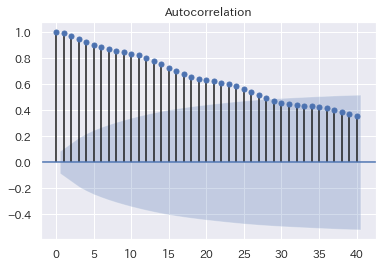

In [21]:
fig = sm.graphics.tsa.plot_acf(y_series,lags=nlags)

## 階差系列の分析

ひとつ前の値との差分をとった系列を階差系列とよぶ。

$\Delta y_n = y_{n} - y_{n-1}$


,t,y,y_fillna,y_diff
0,2020-07-01 01:00:00+09:00,42.29,42.29,NaN
1,2020-07-01 02:00:00+09:00,42.31,42.31,0.02
2,2020-07-01 03:00:00+09:00,42.32,42.32,0.01
3,2020-07-01 04:00:00+09:00,42.43,42.43,0.11
4,2020-07-01 05:00:00+09:00,42.52,42.52,0.09
...,...,...,...,...
522,2020-07-22 19:00:00+09:00,43.76,43.76,0.03
523,2020-07-22 20:00:00+09:00,43.67,43.67,-0.09
524,2020-07-22 21:00:00+09:00,43.55,43.55,-0.12
525,2020-07-22 22:00:00+09:00,43.34,43.34,-0.21


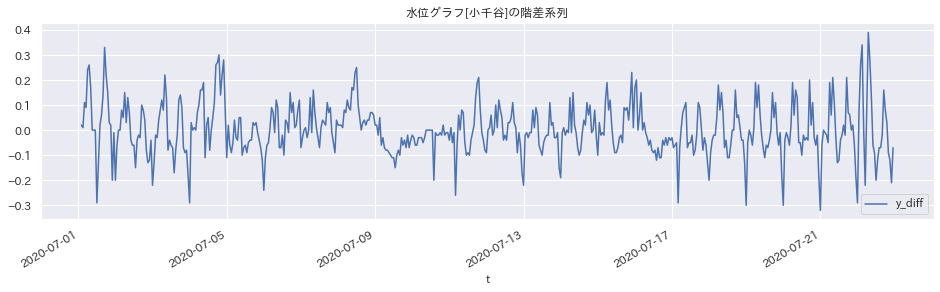

In [22]:
# 欠損データの補間を行わない場合
#df_timeseries['y_diff'] = df_timeseries['y'].diff()
# 欠損データを補間を行う場合
df_timeseries['y_diff'] = df_timeseries['y_fillna'].diff()
display(df_timeseries)
df_timeseries.plot(x='t', y='y_diff', figsize=(16,4), title='{}の階差系列'.format(strtitle))



ヒストグラムをプロット


Text(0.5, 1.0, '水位グラフ[小千谷]')

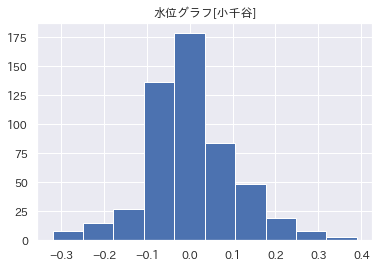

In [23]:
ax = df_timeseries.hist('y_diff')
ax[0][0].set_title(strtitle)

原系列 $y_n$ と階差系列 $\Delta y_n$ のCSVへの出力

In [24]:
df_timeseries.to_csv('./data/sample02_03.csv',index=False)